# Objetivo 

Identificar patologías en tomografías pulmonares asociadas al COVID por medio de machine learning.


La idea de este proyecto consiste en tener 2 distintas formas de extraer las caracteristicas de las tomografías pulmonares y a cada tecnica probarla con 3 modelos:

1. Naive Bayes
2. SVM
3. Red Neuronal

Clasificando pixel por pixel a que clase pertenece. Siendo las clases:
* Vidrio esmerilado la clase 1
* Consolidacion la clase 2
* Efisema pleural la 3
* La clase 0 son los pixeles que no presentan ninguna irregularidad

Las imagenes provienen de la página web: http://medicalsegmentation.com/covid19/


## Se muestra las imágenes con sus mascaras

In [3]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from skimage.feature import greycomatrix, greycoprops
import random

In [4]:
def extraer_pixel(categoria,original,mascara):
    img3=np.ones([512,512])
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            if mascara[i,j]==categoria:
                img3[i,j]=original[i,j]
            else:
                img3[i,j]=-1500#volverlo negro
    return img3

Se cargan las imagenes en formato nib

In [5]:
train_img = nib.load(os.path.join("tr_im.nii"))

In [6]:
train_mask=nib.load(os.path.join("tr_mask.nii"))

In [7]:
img1=train_img.get_fdata()[:,:,1].T
img2=train_mask.get_fdata()[:,:,1].T

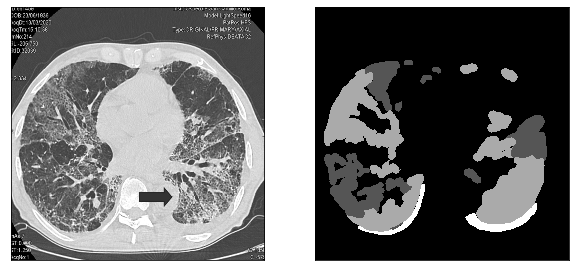

In [8]:
l=[img1,img2]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,grafica in enumerate(axes):
    grafica.imshow(l[i],cmap="gray")
    grafica.set_xticks([])
    grafica.set_yticks([])

A continuacion se hace un preprocesamiento de las imagenes para que puedan ser suministradas al modelo Naive Bayes y SVM, ya que no los acepta de otra manera. Y se muestran las imagenes despues del cambio para observar si hay una perdida de nitidez.

### MinMaxScaler

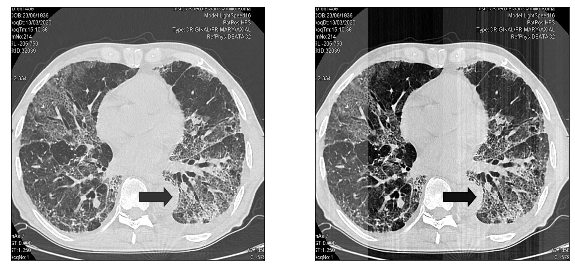

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1000))
imgf = min_max_scaler.fit_transform(img1)
l=[img1,imgf]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,grafica in enumerate(axes):
    grafica.imshow(l[i],cmap="gray")
    grafica.set_xticks([])
    grafica.set_yticks([])

### Float to int

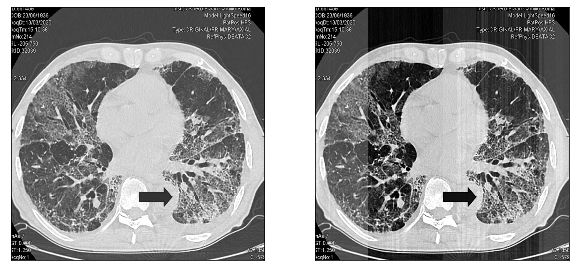

In [10]:
imgf = nib.casting.float_to_int(imgf,np.int16)
l=[img1,imgf]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,grafica in enumerate(axes):
    grafica.imshow(l[i],cmap="gray")
    grafica.set_xticks([])
    grafica.set_yticks([])

### Filtro

Se les aplica un filtro Gaussiano para que el centro este mas nitido y a medida que los pixeles se alejen del centro, se vayan enborronando y asi sean mas homogeneos, ya que lo que nos interesa es lo que esta al centro de la imagen.

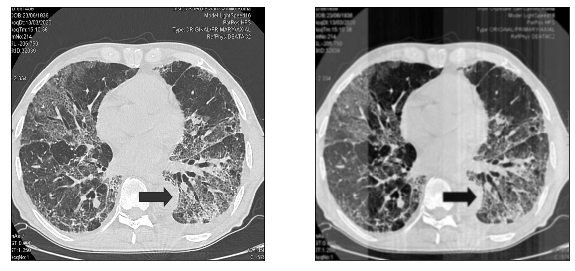

In [11]:
from scipy import ndimage
imgf = ndimage.gaussian_filter(imgf, sigma = 1.5)
l=[img1,imgf]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,grafica in enumerate(axes):
    grafica.imshow(l[i],cmap="gray")
    grafica.set_xticks([])
    grafica.set_yticks([])

A continuacion se muestran de manera separada las 3 patologias asociadas al COVID.

In [12]:
cat1=extraer_pixel(1.,img1,img2)
cat2=extraer_pixel(2.,img1,img2)
cat3=extraer_pixel(3.,img1,img2)

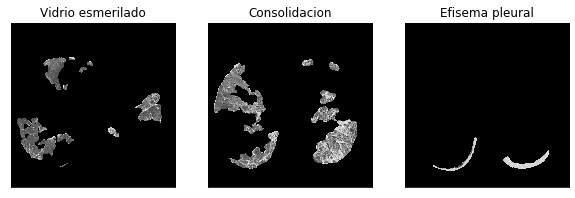

In [13]:
l=[cat1,cat2,cat3]
etiqueta=["Vidrio esmerilado", "Consolidacion","Efisema pleural"]
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(10,5))
for i,grafica in enumerate(axes):
    grafica.imshow(l[i],cmap="gray")
    grafica.set_title(etiqueta[i])
    grafica.set_xticks([])
    grafica.set_yticks([])

## Construir dataframe con GLCM

Para la primera tecnica de extraccion de caracteristicas se planea diferenciar las clases en funcion de la textura de la imagen, para ello se ocupa una matriz GLCM, posteriormente se obtienen 4 caracteristicas:

1. Contraste: Devuelve una medida del contraste de intensidad entre un píxel y su vecino en toda la imagen. El contraste es 0 para una imagen constante

2. Homogeneidad: Devuelve un valor que mide la proximidad de la distribución de elementos en el GLCM a la diagonal GLCM.

3. ASM: Devuelve la uniformidad, a mayor ASM, mayor uniformidad (menos variación en los niveles de gris), si la ASM es 1, la imagen es completamente uniforme.

4. Correlación: Devuelve una medida de lo correlacionado que está un píxel con su vecino en toda la imagen.



### Debido a que es una tecnica muy pesada, se paralelizo este proceso con 5 procesadores:

In [3]:

def glcm(conn,empieza,acaba):
    from sklearn import preprocessing
    from collections import Counter
    from skimage.feature import greycomatrix, greycoprops
    import nibabel as nib
    import os
    import numpy as np
    from scipy import misc
    from scipy import ndimage
    
    train_img = nib.load(os.path.join("tr_im.nii"))
    train_mask=nib.load(os.path.join("tr_mask.nii"))
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1000))
    
    
    ventanas=[]
    for imagen in range(empieza,acaba):
        img=train_img.get_fdata()[:,:,imagen].T
        mask=train_mask.get_fdata()[:,:,imagen].T

        img= min_max_scaler.fit_transform(img)
        img= nib.casting.float_to_int(img,np.int16)
        img= ndimage.gaussian_filter(img, sigma = 1.5)
        for i in range(0,len(img[0])-3,4):
            for j in range(0,len(img[1])-3,4):
                glcm = greycomatrix(img[j:j+4,i:i+4], distances=[1], angles=[0],levels=1001,
                            symmetric=True, normed=True)

                counter = Counter(mask[j:j+4,i:i+4].reshape(16))

                ventanas.append([greycoprops(glcm,"contrast"),greycoprops(glcm,"homogeneity"),
                                 greycoprops(glcm,"ASM"),greycoprops(glcm,"correlation"),counter.most_common()[0][0]])            

    conn.send(ventanas)
    conn.close()



In [ ]:
from multiprocessing import Process, Pipe

if __name__ == '__main__':
    parent_conn1, child_conn1 = Pipe()
    parent_conn2, child_conn2 = Pipe()
    parent_conn3, child_conn3 = Pipe()
    parent_conn4, child_conn4 = Pipe()
    parent_conn5, child_conn5 = Pipe()
    
    p1 = Process(target=glcm, args=(child_conn1,0,20))
    p2 = Process(target=glcm, args=(child_conn2,20,40))
    p3 = Process(target=glcm, args=(child_conn3,40,60))
    p4 = Process(target=glcm, args=(child_conn4,60,80))
    p5 = Process(target=glcm, args=(child_conn5,80,100))
    
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    
    ven=parent_conn1.recv()+parent_conn2.recv()+parent_conn3.recv()+parent_conn4.recv()+parent_conn5.recv()

    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()

In [7]:
cols=["contraste","homogeneidad","asm","correlacion","categoria"]
df=pd.DataFrame(ven,columns=cols)

Debido a que consume mucha RAM este proceso se decidió pasarlo a csv y reiniciar el kernel.

In [10]:
df.to_csv("pixeles1.csv",index=False)
df.head()

## Leemos el dataframe

In [52]:
df=pd.read_csv("pixeles1.csv")
df.head()

,contraste,homogeneidad,asm,correlacion,categoria
0,0.333333,0.833333,0.5,-0.2,0.0
1,0.333333,0.833333,0.5,-0.2,0.0
2,0.333333,0.833333,0.5,-0.2,0.0
3,0.333333,0.833333,0.5,-0.2,0.0
4,0.333333,0.833333,0.5,-0.2,0.0


Vemos la proporcion de las categorias 

Text(0,0.5,'Frecuencia')

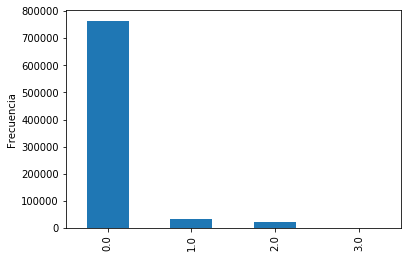

In [53]:
df["categoria"].value_counts().plot(kind = 'bar')
plt.ylabel("Frecuencia")

In [54]:
df[df.categoria==1].shape

(31533, 5)

Se hace un muestreo de la clase 0 para que quede aproximadamente a la misma de la clase 1 para no tener una clasificacion desbalanceada

In [57]:
cat0=df[df.categoria==0].sample(n=32000)#numero aproximadamente igual a la clase 1
df=pd.concat([cat0,df[df.categoria!=0]])

Text(0,0.5,'Frecuencia')

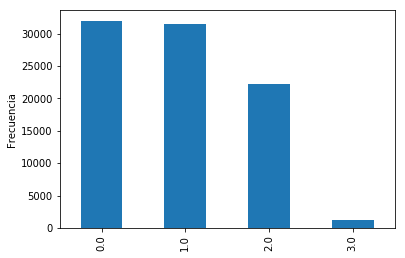

In [58]:
df["categoria"].value_counts().plot(kind = 'bar')
plt.ylabel("Frecuencia")

In [9]:
df.to_csv("pix_balan.csv",index=False)

In [59]:
df=pd.read_csv("pix_balan.csv")
df.head()

,contraste,homogeneidad,asm,correlacion,categoria
0,12.083333,0.245945,0.045139,0.962991,0.0
1,320.166667,0.004229,0.048611,0.622420,0.0
2,0.333333,0.833333,0.500000,-0.200000,0.0
3,257.916667,0.005428,0.041667,0.475687,0.0
4,0.333333,0.833333,0.277778,0.333333,0.0


Se sobremuestrea para tener el mismo numero de clases

In [61]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
X=df.iloc[:,:4]
y=df.iloc[:,4]

X, y=oversample.fit_resample(X, y)


Verificamos que tengan la misma cantidad de datos

In [62]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0.0: 32000, 2.0: 32000, 1.0: 32000, 3.0: 32000})


## Modelado con Naive Bayes

In [63]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1000))
X=min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [64]:
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

MultinomialNB()

In [65]:
y_pred=modelo.predict(X_test)

In [66]:
print("Resumen de evaluacion del modelo Naive Bayes (GLCM)")
print(classification_report(y_test,y_pred))

Resumen de evaluacion del modelo Naive Bayes (GLCM)
              precision    recall  f1-score   support

         0.0       0.50      0.37      0.43      9697
         1.0       0.32      0.62      0.43      9563
         2.0       0.33      0.17      0.23      9568
         3.0       0.30      0.24      0.27      9572

    accuracy                           0.35     38400
   macro avg       0.36      0.35      0.34     38400
weighted avg       0.36      0.35      0.34     38400



## Modelado con SVC lineal

In [67]:
from sklearn.svm import LinearSVC
modelo=LinearSVC(loss='squared_hinge', multi_class = 'ovr', max_iter=10000, dual = False)
modelo.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=10000)

In [68]:
y_pred=modelo.predict(X_test)

In [69]:
print("Resumen de evaluacion del modelo SVM lineal (GLCM)")
print(classification_report(y_test,y_pred))

Resumen de evaluacion del modelo SVM lineal (GLCM)
              precision    recall  f1-score   support

         0.0       0.47      0.40      0.43      9697
         1.0       0.34      0.55      0.42      9563
         2.0       0.32      0.25      0.28      9568
         3.0       0.31      0.23      0.26      9572

    accuracy                           0.36     38400
   macro avg       0.36      0.36      0.35     38400
weighted avg       0.36      0.36      0.35     38400



## Modelado con una red neuronal

In [70]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
X=df.iloc[:,:4]
y=df.iloc[:,4]

X, y=oversample.fit_resample(X, y)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [72]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = 4))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))

model.add(Dense(units = 4 , activation = 'sigmoid'))

Using TensorFlow backend.


In [73]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['acc'])

In [74]:
model.fit(X_train,y_train ,epochs = 5)

Epoch 1/5
89600/89600 [==============================] - 6s 69us/step - loss: 1.3253 - acc: 0.2528
Epoch 2/5
89600/89600 [==============================] - 4s 47us/step - loss: 1.3126 - acc: 0.2549
Epoch 3/5
89600/89600 [==============================] - 4s 47us/step - loss: 1.3107 - acc: 0.2503
Epoch 4/5
89600/89600 [==============================] - 4s 47us/step - loss: 1.3094 - acc: 0.2546
Epoch 5/5
89600/89600 [==============================] - 4s 49us/step - loss: 1.3086 - acc: 0.2549


In [75]:
y_pred=model.predict(X_test)

In [76]:
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())

In [77]:
print("Resumen de evaluacion de la red neuronal (GLCM)")
print(classification_report(y_test,y_p))

Resumen de evaluacion de la red neuronal (GLCM)
              precision    recall  f1-score   support

         0.0       0.23      0.58      0.33      9604
         1.0       0.00      0.00      0.00      9564
         2.0       0.00      0.00      0.00      9586
         3.0       0.30      0.44      0.36      9646

    accuracy                           0.26     38400
   macro avg       0.13      0.26      0.17     38400
weighted avg       0.13      0.26      0.17     38400



/home/kenia/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Modelo con la imagen aplanada con posición

Se extrae el valor del pixel y la pocision

In [65]:
pixels=[]
for imagen in range(train_img.shape[2]):
    img=train_img.get_fdata()[:,:,imagen].T
    mask=train_mask.get_fdata()[:,:,imagen].T
    for i in range(len(img[0])):
        for j in range(len(img[1])):

            pixels.append([img[i][j],mask[i,j]])
            
df=pd.DataFrame(pixels,columns=("pixels","categoria"))
pixels=[]


In [66]:
pocision=[]
for img in range(train_img.shape[2]):
    img=train_img.get_fdata()[:,:,img].T
    for i in range(len(img[0])):
        for j in range(len(img[1])):
            pocision.append([i,j])
pos=pd.DataFrame(pocision,columns=("x","y"))


In [67]:
df=pd.concat([df,pos],axis=1)
df.to_csv("pixeles_pos.csv",index=False)

In [26]:
df=pd.read_csv("pixeles_pos.csv")
df.head()

,pixels,categoria,x,y
0,-1408.510638,0.0,0,0
1,-1408.510638,0.0,0,1
2,-1408.510638,0.0,0,2
3,-1408.510638,0.0,0,3
4,-1408.510638,0.0,0,4


Vemos la proporcion de las clases

Text(0, 0.5, 'Frecuencia')

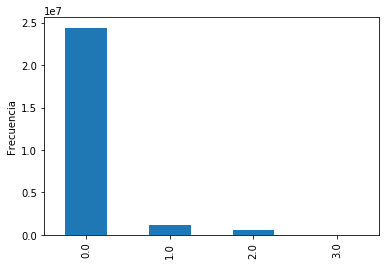

In [27]:
df["categoria"].value_counts().plot(kind = 'bar')
plt.ylabel("Frecuencia")

Hacemos un muestreo de la clase 0 para que tenga las mismas instancias de la clase 1

In [28]:
df[df.categoria==1].shape

(1196461, 4)

In [29]:
cat0=df[df.categoria==0].sample(n=1196461)#numero aproximadamente igual a la clase 1
df=pd.concat([cat0,df[df.categoria!=0]])

Text(0, 0.5, 'Frecuencia')

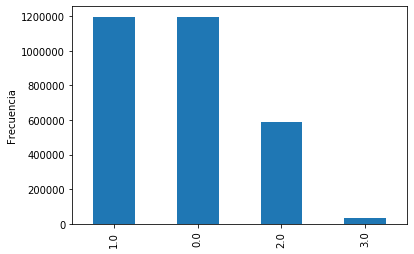

In [30]:
df["categoria"].value_counts().plot(kind = 'bar')
plt.ylabel("Frecuencia")

Generamos mas muestras para que tengan la misma cantidad de instancias en todas las clases

In [31]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
y=df.iloc[:,1].values
df.drop(["categoria"],axis=1,inplace=True)
X=df

X, y=oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [32]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0.0: 1196461, 1.0: 1196461, 2.0: 1196461, 3.0: 1196461})


## Modelado con Naive Bayes

In [36]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1000))
X=min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [37]:
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

MultinomialNB()

In [38]:
y_pred=modelo.predict(X_test)

In [39]:
print("Resumen de evaluacion del modelo Naive Bayes (Posición)")
print(classification_report(y_test,y_pred))

Resumen de evaluacion del modelo Naive Bayes (Posición)
              precision    recall  f1-score   support

         0.0       0.48      0.39      0.43    358201
         1.0       0.33      0.33      0.33    359436
         2.0       0.15      0.05      0.08    358948
         3.0       0.34      0.62      0.43    359169

    accuracy                           0.35   1435754
   macro avg       0.32      0.35      0.32   1435754
weighted avg       0.32      0.35      0.32   1435754



## Modelado con SVM lineal

In [8]:
from sklearn.svm import LinearSVC
modelo=LinearSVC(loss='squared_hinge', multi_class = 'ovr', max_iter=10000, dual = False)
modelo.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=10000)

In [10]:
y_pred=modelo.predict(X_test)

In [11]:
print("Resumen de evaluacion del modelo SVM lineal (Posición)")
print(classification_report(y_test,y_pred))

Resumen de evaluacion del modelo SVM lineal (Posición)
              precision    recall  f1-score   support

         0.0       0.41      0.29      0.34    358495
         1.0       0.48      0.65      0.55    360205
         2.0       0.61      0.12      0.20    357915
         3.0       0.54      0.94      0.69    359139

    accuracy                           0.50   1435754
   macro avg       0.51      0.50      0.45   1435754
weighted avg       0.51      0.50      0.45   1435754



## Modelado con una red neuronal

In [40]:
df=pd.read_csv("pixeles_pos.csv")

cat0=df[df.categoria==0].sample(n=1196461)#numero aproximadamente igual a la clase 1
df=pd.concat([cat0,df[df.categoria!=0]])




In [41]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
y=df.iloc[:,1].values
df.drop(["categoria"],axis=1,inplace=True)
X=df

X, y=oversample.fit_resample(X, y)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X=min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [42]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0.0: 1196461, 1.0: 1196461, 2.0: 1196461, 3.0: 1196461})


In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten


import tensorflow as tf
model = Sequential()
model.add(Flatten(input_shape=[3]))
model.add(Dense(units = 100 , activation = 'relu' ))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 4 , activation = 'softmax'))

In [44]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['acc'])

In [45]:
model.fit(X_train,y_train ,epochs = 5)

Epoch 1/5
104691/104691 [==============================] - 62s 589us/step - loss: 0.6759 - acc: 0.7204
Epoch 2/5
104691/104691 [==============================] - 63s 603us/step - loss: 0.6349 - acc: 0.7383
Epoch 3/5
104691/104691 [==============================] - 64s 610us/step - loss: 0.6225 - acc: 0.7434
Epoch 4/5
104691/104691 [==============================] - 65s 624us/step - loss: 0.6162 - acc: 0.7463
Epoch 5/5
104691/104691 [==============================] - 66s 628us/step - loss: 0.6116 - acc: 0.7481


Se muestra la arquitectura de la red neuronal

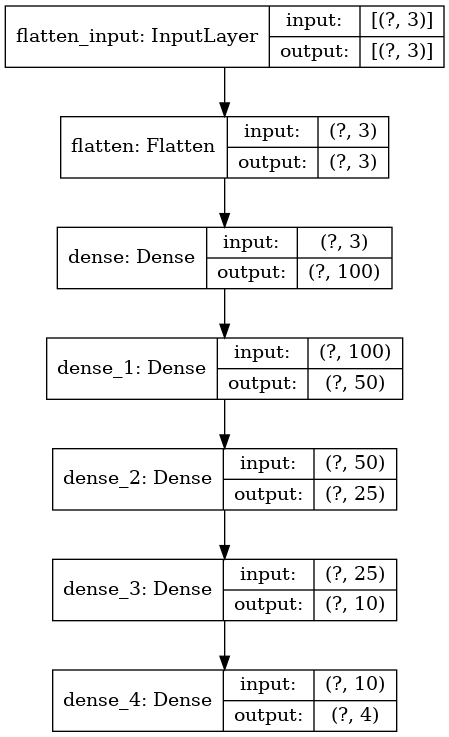

In [46]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)


Se guarda el modelo (tanto la arquitectura como los parametros entrenados)

In [8]:
model.save('red_neuronal.h5')


In [3]:
import keras
model = keras.models.load_model('red_neuronal.h5')


In [47]:
y_pred=model.predict(X_test)

In [48]:
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())

In [49]:
print("Resumen de evaluacion de la red neuronal (Posición)")
print(classification_report(y_test,y_p))

Resumen de evaluacion de la red neuronal (Posición)
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82    358552
         1.0       0.69      0.77      0.73    358763
         2.0       0.67      0.52      0.59    359139
         3.0       0.78      0.93      0.85    359300

    accuracy                           0.75   1435754
   macro avg       0.75      0.75      0.75   1435754
weighted avg       0.75      0.75      0.75   1435754



### A continuacion se prueban imagenes con la red neuronal 

In [41]:
train_img = nib.load(os.path.join("tr_im.nii"))
train_mask=nib.load(os.path.join("tr_mask.nii"))
pixels=[]
img=train_img.get_fdata()[:,:,8].T

for i in range(len(img[0])):
    for j in range(len(img[1])):

        pixels.append([img[i][j],i,j])
            
df_test=pd.DataFrame(pixels,columns=("pixels","x","y"))
X=df_test
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X=min_max_scaler.fit_transform(X)
y_pred=model.predict(X)
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())
    
df_test["categoria"]=y_p

In [42]:
df_test.categoria.unique()

array([0, 1, 2, 3])

In [43]:
def plotPrediction_mask(test, num):
    plt.figure(3,figsize=(10,7))
    plt.rcParams['image.cmap'] = 'gray'
    
    img1=train_img.get_fdata()[:,:,num].T
    img2=train_mask.get_fdata()[:,:,num].T
    
    plt.subplot(231)
    plt.imshow(img1,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Imagen original")
    
    plt.subplot(232)
    plt.imshow(img2,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Mascara")
    plt.subplot(233)
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=85
    test.loc[(test["categoria"]==2), "color"]=170
    test.loc[(test["categoria"]==3), "color"]=255
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Prediccion")
    
    plt.subplot(234)
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=85
    test.loc[(test["categoria"]==2), "color"]=0
    test.loc[(test["categoria"]==3), "color"]=0
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Vidrio esmerilado")
    
    
    plt.subplot(235)
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=0
    test.loc[(test["categoria"]==2), "color"]=170
    test.loc[(test["categoria"]==3), "color"]=0
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Consolidacion")
    
    plt.subplot(236)
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=0
    test.loc[(test["categoria"]==2), "color"]=0
    test.loc[(test["categoria"]==3), "color"]=255
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Derrame pleural")
    plt.show()

## Imagen de entrenamiento

Probamos la red neuronal con una imagen del entrenamiento

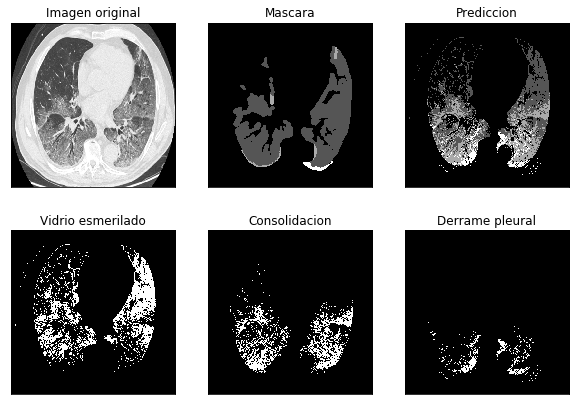

In [44]:
plotPrediction_mask(df_test,8)

## Imagen de test

Probamos la imagen con una imagen de test

In [21]:
test_img=nib.load(os.path.join("val_im.nii"))

pixels=[]
img=train_img.get_fdata()[:,:,0].T
for i in range(len(img[0])):
    for j in range(len(img[1])):

        pixels.append([img[i][j],i,j])
            
df_test=pd.DataFrame(pixels,columns=("pixels","x","y"))
y_pred=model.predict(df_test)
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())
    
df_test["categoria"]=y_p

In [22]:
def plotPrediction_tests(test, num):
    plt.figure(3,figsize=(10,7))
    plt.rcParams['image.cmap'] = 'gray'
    
    img1=test_img.get_fdata()[:,:,num].T
    
    plt.subplot(231)
    plt.imshow(img1,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Imagen original")
    
    plt.subplot(232)
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=85
    test.loc[(test["categoria"]==2), "color"]=170
    test.loc[(test["categoria"]==3), "color"]=255
    plt.rcParams['image.cmap'] = 'gray'
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Prediccion")
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=85
    test.loc[(test["categoria"]==2), "color"]=170
    test.loc[(test["categoria"]==3), "color"]=255
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Prediccion")
    
    plt.subplot(234)
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=85
    test.loc[(test["categoria"]==2), "color"]=0
    test.loc[(test["categoria"]==3), "color"]=0
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Vidrio esmerilado")
    
    
    plt.subplot(235)
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=0
    test.loc[(test["categoria"]==2), "color"]=170
    test.loc[(test["categoria"]==3), "color"]=0
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Consolidacion")
    
    plt.subplot(236)
    
    
    test.loc[(test["categoria"]==0), "color"]=0
    test.loc[(test["categoria"]==1), "color"]=0
    test.loc[(test["categoria"]==2), "color"]=0
    test.loc[(test["categoria"]==3), "color"]=255
    plt.rcParams['image.cmap'] = 'gray'
    
    color=test["color"].astype(int)
    imagen=np.array(color).reshape(512,512)
    
    plt.imshow(imagen,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Derrame pleural")
    plt.show()

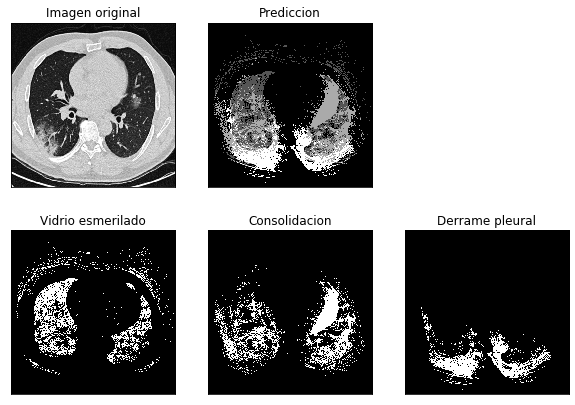

In [23]:
plotPrediction_tests(df_test,0)

In [29]:
pixels=[]
img=train_img.get_fdata()[:,:,3].T
for i in range(len(img[0])):
    for j in range(len(img[1])):

        pixels.append([img[i][j],i,j])
            
df_test=pd.DataFrame(pixels,columns=("pixels","x","y"))
y_pred=model.predict(df_test)
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())
    
df_test["categoria"]=y_p

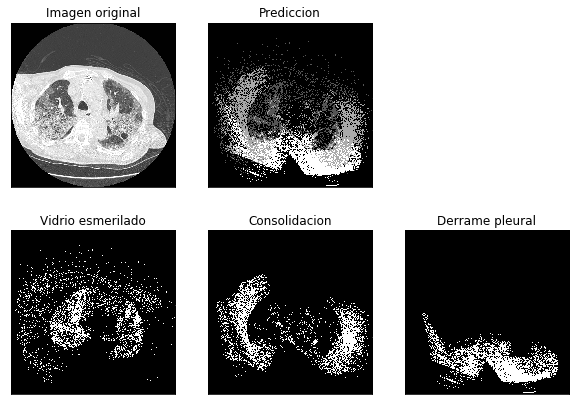

In [30]:
plotPrediction_tests(df_test,3)

In [43]:
pixels=[]
img=train_img.get_fdata()[:,:,4].T
for i in range(len(img[0])):
    for j in range(len(img[1])):

        pixels.append([img[i][j],i,j])
            
df_test=pd.DataFrame(pixels,columns=("pixels","x","y"))
y_pred=model.predict(df_test)
y_p=[]
for y in y_pred:
    y_p.append(y.argmax())
    
df_test["categoria"]=y_p

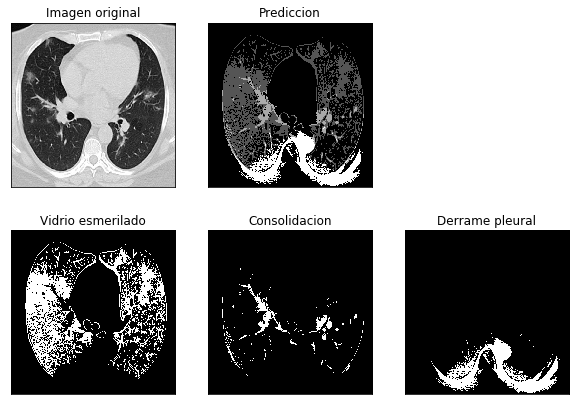

In [44]:
plotPrediction_tests(df_test,4)

# Conclusion

En la primera tecnica de extraccion de caracteristicas la razon mas probable por la cual no funciono fue debido a que la matriz GLCM nos ayuda en la diferenciacion de texturas en imagenes y las patologias no presentaban un cambio de textura importante.

En la extraccion de caracteristicas en donde sacamos la pocision y el valor del pixel fue claramente mejor en todos los modelos, destacando la red neuronal. Aunque se puede ver que hay una clara exageracion en las patologias que predice la red neuronal en todas las clases, posiblemente sea porque el conjunto de entrenamiento no sea el adecuado, por ejemplo, que las mascaras que se sacaron con expertos, no fueron muy precisas.